### Import

In [1]:
!pip install rdkit

In [51]:
import pandas as pd
import numpy as np
import os
import random

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Crippen
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

### DataLoad

In [10]:
# SMILES 데이터를 분자 지문으로 변환
def get_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    descriptors = {
        'MolecularWeight': Descriptors.MolWt(mol),
        'LogP': Crippen.MolLogP(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol)
    }
    return descriptors

In [11]:
# 학습 ChEMBL 데이터 로드
chembl_data = pd.read_csv('train.csv')  # 예시 파일 이름
chembl_data.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...


### Data Pre-processing

In [12]:
descriptors = chembl_data['Smiles'].apply(get_descriptors)
descriptors_df = pd.DataFrame(descriptors.tolist(), index=chembl_data.index)

In [13]:
df = pd.concat([chembl_data, descriptors_df], axis=1)

In [14]:
df

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles,MolecularWeight,LogP,NumHDonors,NumHAcceptors
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...,995.188,2.74360,6,13
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,535.624,2.72090,2,8
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,537.596,1.56720,2,9
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,545.566,2.43350,2,8
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...,936.189,6.49322,5,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,CHEMBL380009,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1147720,30000.000,4.52,O=C(Nc1nc2cc[nH]cc-2n1)c1cccc([N+](=O)[O-])c1,283.247,2.07000,2,5
1948,CHEMBL377654,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1147720,30000.000,4.52,CCCCn1c(NC(=O)c2cccc(Cl)c2)nc2ccccc21,327.815,4.74210,1,3
1949,CHEMBL208667,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1147720,30000.000,4.52,O=C(Nc1nc2cc(F)c(F)cc2[nH]1)c1cccc([N+](=O)[O-...,318.239,3.00160,2,4
1950,CHEMBL3403453,IC50,'=',42000.000,nM,4.38,CHEMBL3407004,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL3400143,42000.000,4.38,OC[C@H]1C[C@@H](Nc2nc(Nc3ccccc3)ncc2-c2nc3cccc...,449.536,3.01140,5,9


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  1952 non-null   object 
 1   Standard Type       1952 non-null   object 
 2   Standard Relation   1952 non-null   object 
 3   Standard Value      1952 non-null   float64
 4   Standard Units      1952 non-null   object 
 5   pChEMBL Value       1952 non-null   float64
 6   Assay ChEMBL ID     1952 non-null   object 
 7   Target ChEMBL ID    1952 non-null   object 
 8   Target Name         1952 non-null   object 
 9   Target Organism     1952 non-null   object 
 10  Target Type         1952 non-null   object 
 11  Document ChEMBL ID  1952 non-null   object 
 12  IC50_nM             1952 non-null   float64
 13  pIC50               1952 non-null   float64
 14  Smiles              1952 non-null   object 
 15  MolecularWeight     1952 non-null   float64
 16  LogP  

In [49]:
df_numeric_columns = df.select_dtypes(include=['float64', 'int64'])

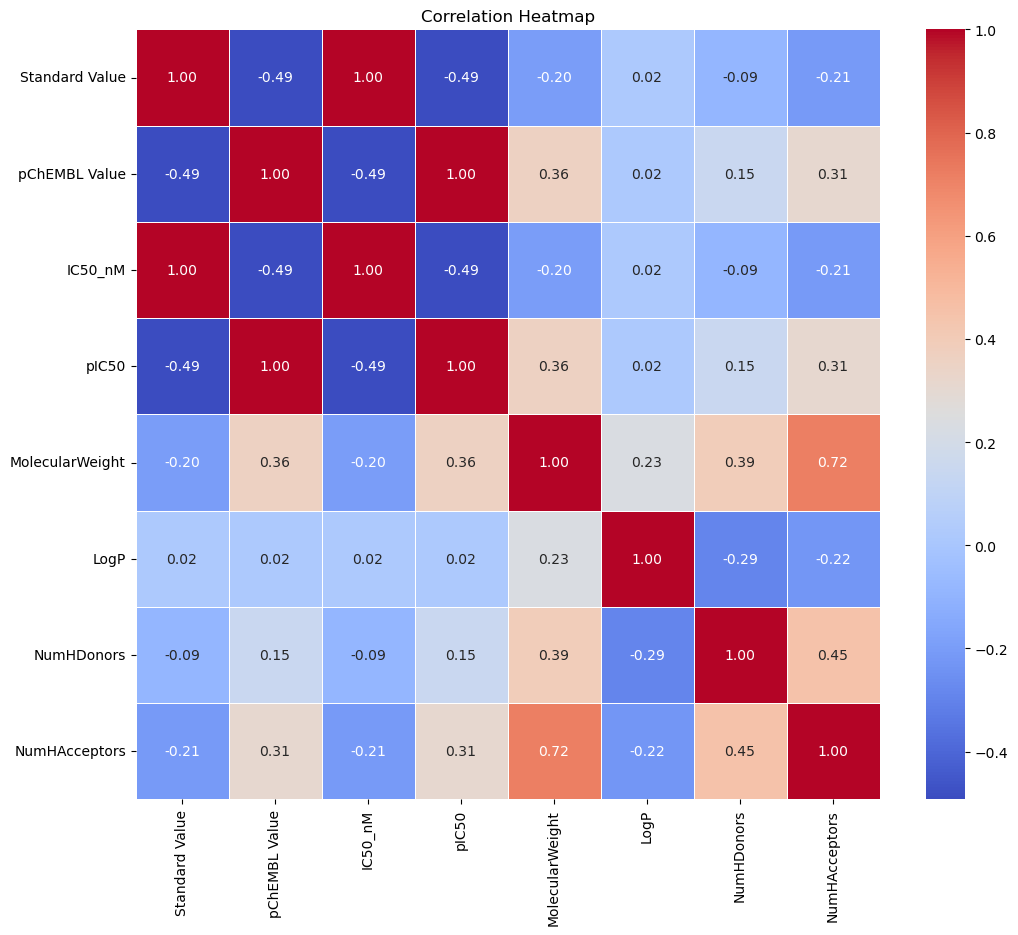

In [52]:
# 상관관계 계산
correlation_matrix = df_numeric_columns.corr()

# 히트맵 생성
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [65]:
X = df[['MolecularWeight', 'NumHAcceptors']]
y = df['pIC50']

In [66]:
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=42)

In [67]:
print(train_x.shape)

(1366, 2)


In [68]:
print(train_y.shape)

(1366,)


### Train & Validation

In [69]:
# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(random_state=CFG['SEED'])
model.fit(train_x, train_y)

RandomForestRegressor(random_state=42)

In [70]:
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

# Validation 데이터로부터의 학습 모델 평가
val_y_pred = model.predict(val_x)
mse = mean_squared_error(pIC50_to_IC50(val_y), pIC50_to_IC50(val_y_pred))
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')

RMSE: 2328.6249140707596


### Inference

In [71]:
test = pd.read_csv('./test.csv')

In [72]:
test

,ID,Smiles
0,TEST_000,O=C(C1=CSC(C2=CC=CN=C2)=N1)NC3=CC(NC4CCN(C)CC4...
1,TEST_001,N#CC1=CC(C=C2)=C(C=C1)N2C(N=C3)=NC(NC4CCCCC4)=...
2,TEST_002,N#CC(C=C1)=C(N[C@@H]2CCNC2)C=C1NC(N=C3)=NC=C3C...
3,TEST_003,N#CC(C=C1)=CC=C1NC(N=C2)=NC(NC3CC(NC(C=C)=O)CC...
4,TEST_004,N#CC(C=C1)=CC=C1NC(N=C2)=NC(NC3CC(N)CC3)=C2C(C...
...,...,...
108,TEST_108,N#CC1=CC(C=C2)=C(C=C1)N2C(N=C3)=NC(N4CCOCC4)=C...
109,TEST_109,O=C(C1=CSC(C2=CC=NC=C2)=N1)NC3=CC(NC4CCN(C(C)C...
110,TEST_110,N#Cc1ccc(Nc2ncc(cn2)c3cnn(c3)C4CCNCC4)cc1N[C@@...
111,TEST_111,O=C(C)N(CC1)CCC1N2N=CC(C3=CN=C(N4C(C=CC(C#N)=C...


In [73]:
test_descriptors = test['Smiles'].apply(get_descriptors)
test_descriptors_df = pd.DataFrame(test_descriptors.tolist(), index=test.index)

In [74]:
test_df = pd.concat([test, test_descriptors_df], axis=1)

In [76]:
test_x = test_df[['MolecularWeight', 'NumHAcceptors']]

In [77]:
test_y_pred = model.predict(test_x)

### Submission

In [78]:
submit = pd.read_csv('./sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(test_y_pred)
submit.head()

,ID,IC50_nM
0,TEST_000,10.099038
1,TEST_001,12.134088
2,TEST_002,56.639142
3,TEST_003,4.274996
4,TEST_004,31.195907


In [79]:
submit.to_csv('./descriptors_submit.csv', index=False)